# 计算机视觉

## 图像增广

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import PIL
import matplotlib.pyplot as plt

<class 'PIL.JpegImagePlugin.JpegImageFile'>


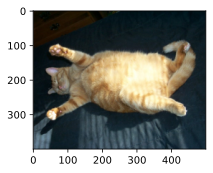

In [2]:
d2l.set_figsize()
img = PIL.Image.open('./PyTorch Source Code/img/cat1.jpg')
print(type(img))
plt.imshow(img)

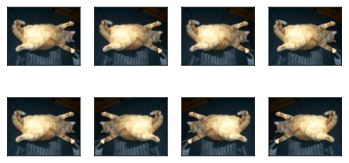

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

'''应用一些transforms自带的图像增广方法'''
apply(img, torchvision.transforms.RandomHorizontalFlip())  # 50%几率纵轴翻转

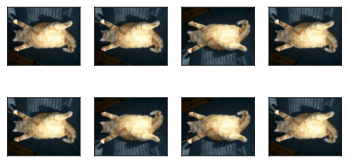

In [4]:
apply(img, torchvision.transforms.RandomVerticalFlip())  # 50%几率横轴翻转

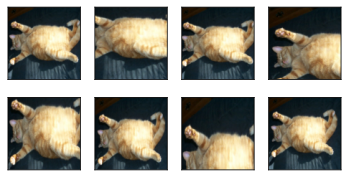

In [5]:
shape_aug = torchvision.transforms.RandomResizedCrop(  # 随机裁剪
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

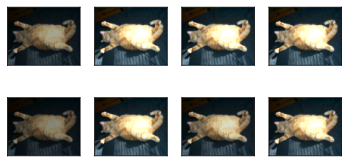

In [6]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0  # 颜色抖动，可改变亮度、对比度、饱和度、色调
))

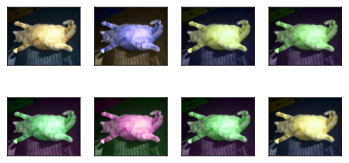

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5  # 这次改变色调
))

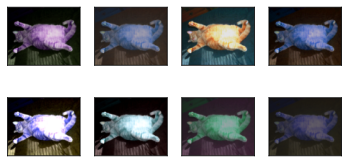

In [8]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5  # 这次改变色调
)
apply(img, color_aug)

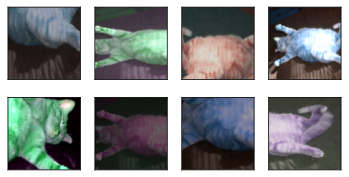

In [9]:
'''结合多种image augment方法'''
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug,
    shape_aug
])
apply(img, augs)

100%|██████████| 170498071/170498071 [00:13<00:00, 12395825.54it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

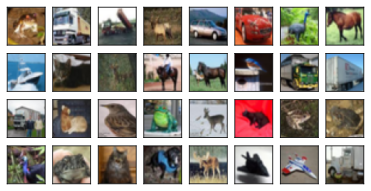

In [10]:
'''将image augment应用于CIFAR-10'''
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

In [11]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()  # 转为tensor以便后续提供给model学习
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# 制作DataLoader
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='../data', train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [12]:
'''使用多GPu进行训练'''
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    # 小批量训练
    if isinstance(X, list):
        # BERT微调所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward() # 自动微分
    trainer.step() # 更新
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices = d2l.try_all_gpus()):
    '''用多GPU进行训练'''
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])  # 多GPU并行
    for epoch in range(num_epochs):
        # 训练损失、训练准确度、样本数、特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices
            )
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    # 最后显示训练准确度、效率等信息
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'loss {metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')    

loss 0.211, train acc 0.927, test acc 0.846
loss 7954.2 examples/sec on [device(type='cuda', index=0)]


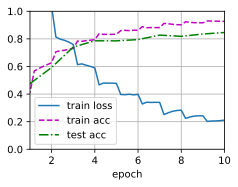

In [13]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

# 使用Xavier均匀分布进行正则化
def init_weights(m):
    if type(m) in [nn.Conv2d, nn.Linear]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    # 两个iter都是DataLoader
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)
    
train_with_data_aug(train_augs, test_augs, net)

## 微调

In [1]:
'''
迁移学习中的常见技巧：fine-tuning
1. 预训练源模型
2. 复制得到一个目标模型，除了输出层外完全相同
3. 向目标模型添加输出层并初始化
4. 在目标数据集上训练目标模型；输出层从头训练，其他所有层将根据源模型参数进行微调
微调有助于在较小的目标数据集上，提高模型的泛化能力
'''
%matplotlib inline
import os
import torch, torchvision
from torch import nn
from d2l import torch as d2l

#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

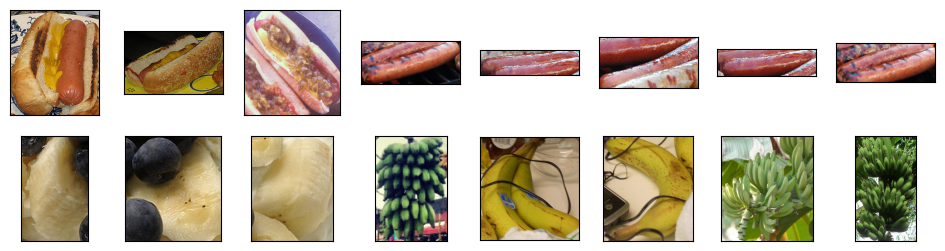

In [2]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

# ImageFolder返回(image, label)元组，因而[0]是图像本身
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.5)

In [12]:
# 使用RGB通道的均值和标准差，初始化每个通道
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
)

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize # 转换为tensor数值后再应用标准化
])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize # 转换为tensor数值后再应用标准化
])

In [13]:
# 使用在ImageNet上预训练的ResNet-18
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.fc

d:\Application\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Application\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\sword/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.9MB/s]


Linear(in_features=512, out_features=1000, bias=True)

In [14]:
# 修改最后一层（全连接层）及重新初始化
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)  # 有无hotdogs出现是一个2-分类问题
nn.init.xavier_uniform_(finetune_net.fc.weight)

d:\Application\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Application\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.0182,  0.0090, -0.0322,  ...,  0.0904, -0.1041, -0.0186],
        [ 0.1044,  0.1046, -0.0119,  ..., -0.0504,  0.0358, -0.0565]],
       requires_grad=True)

loss 0.179, train acc 0.940, test acc 0.932
522.1 examples/sec on [device(type='cuda', index=0)]


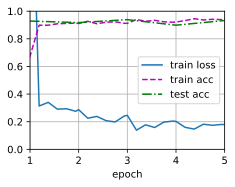

In [16]:
'''微调训练'''
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs), batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs), batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction='none')
    if param_group:
        param_1x = [param for name, param in net.named_parameters()
                    if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params':param_1x}, # 其他层采用默认较小的学习率
                                   {'params':net.fc.parameters(),
                                    'lr':learning_rate * 10}], # 从头开始训练的fc层采用默认学习率的10倍
                                  lr=learning_rate, weight_decay=0.01)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

# 在已经预训练的Resnet-18上进行微调    
train_fine_tuning(finetune_net, 5e-5)

loss 0.340, train acc 0.852, test acc 0.859
527.4 examples/sec on [device(type='cuda', index=0)]


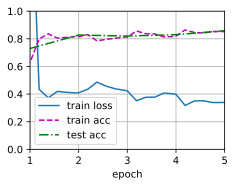

In [18]:
# 对比：不使用fine-tuning，从头开始训练
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

loss 0.472, train acc 0.865, test acc 0.886
1397.6 examples/sec on [device(type='cuda', index=0)]


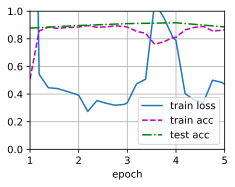

In [25]:
'''练习：在训练期间直接冻结隐藏层参数'''
finetune_net = torchvision.models.resnet18(pretrained=True)
for param in finetune_net.parameters():
    param.requires_grad = False
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)  # 有无hotdogs出现是一个2-分类问题
for param in finetune_net.fc.parameters():
    param.requires_grad = True
nn.init.xavier_uniform_(finetune_net.fc.weight)
train_fine_tuning(finetune_net, 5e-5)

In [27]:
'''练习：利用ImageNet的hotdogs数据改进模型'''
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[934]
hotdog_w.shape  # 是一个1x512的向量

torch.Size([1, 512])

loss 0.175, train acc 0.942, test acc 0.939
517.1 examples/sec on [device(type='cuda', index=0)]


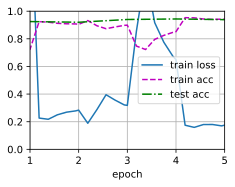

In [38]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
with torch.no_grad():
    finetune_net.fc.weight[0] = hotdog_w
train_fine_tuning(finetune_net, 5e-5)

## 目标检测和边界框

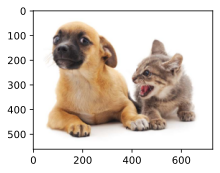

In [1]:
'''目标的位置'''
%matplotlib inline
import torch
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.plt.imread("./PyTorch Source Code/img/catdog.jpg")
d2l.plt.imshow(img)

In [8]:
'''边界框两种表示方法的相互转换'''
#@save
def box_corner_to_center(boxes):
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1 # width
    h = y2 - y1 # height
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes

#@save
def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [9]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [10]:
'''测试转换'''
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

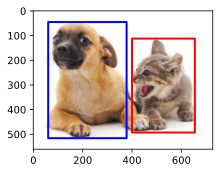

In [14]:
'''画出边界框'''
def bbox_to_rect(bbox, color):
    # (x1, y1, x2, y2) -> ((x1, y1), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2
    )

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

## 锚框